# Image preprocessing and data augmentation


The following tutorial is based on:

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

- Keras provides [multiple functions](https://keras.io/guides/preprocessing_layers/) for image processing as well as data augmentation. In this tuorial, we demonstrate how to use some of them.

## Image classification

### Image preprocessing

- These layers are for standardizing the inputs of an image model:

  - `tf.keras.layers.Resizing`: resizes a batch of images to a target size.


  - `tf.keras.layers.Rescaling`: rescales and offsets the values of a batch of
  image (e.g. go from inputs in the `[0, 255]` range to inputs in the `[0, 1]`
  range.


  - `tf.keras.layers.CenterCrop`: returns a center crop of a batch of images.

  - Review the [Keras image preprocessing documentation](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/) to learn more.


### Image augmentation

- These layers apply random augmentation transforms to a batch of images (they are only active during training):

  - `tf.keras.layers.RandomCrop`
  - `tf.keras.layers.RandomFlip`
  - `tf.keras.layers.RandomTranslation`
  - `tf.keras.layers.RandomRotation`
  - `tf.keras.layers.RandomZoom`
  - `tf.keras.layers.RandomHeight`
  - `tf.keras.layers.RandomWidth`
  - `tf.keras.layers.RandomContrast`


- Review the Keras [image data augmentation](https://keras.io/api/layers/preprocessing_layers/image_augment) documentation to learn more.

## Introduction


- This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. 


- We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.


- We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:


In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  59.7M      0  0:00:13  0:00:13 --:--:-- 60.4M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls


MSR-LA - 3467.docx
PetImages
cnn.ipynb
convolutional-nn.ipynb
convolutional.md
data-import-preprocessing.ipynb
deep-learning.md
fashion-mnist-exercises-solution.ipynb
fashion-mnist-exercises.ipynb
fashion-mnist.ipynb
hugging-face.md
image_classification_from_scratch.ipynb
imdb_model
intro.md
jena_climate_2009_2016.csv
jena_climate_2009_2016.csv.zip
jena_conv.keras
jena_dense.keras
jena_lstm.keras
jena_lstm_dropout.keras
jena_stacked_gru_dropout.keras
kagglecatsanddogs_3367a.zip
keras-functional-c.ipynb
keras-functional.ipynb
keras-imdb-c.ipynb
keras-imdb.ipynb
keras-preprocesing.md
keras-sequential-c.ipynb
keras-sequential.ipynb
keras-subclass-c.ipynb
keras-subclass.ipynb
keras-time-tutorial.ipynb
keras-time.ipynb
keras-timeseries_weather_forecasting.ipynb
keras-tuner.ipynb
logs
mnist-cnn-c.ipynb
mnist-cnn.ipynb
mnist-pytorch.ipynb
mnist-tensorflow.ipynb
model-exercises.ipynb
model.png
my_hd_classifier
readme[1].txt
reference.md
regression-structured.md
sentiment_classifier.png
sentime

Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [4]:
!ls PetImages


Cat Dog


### Filter out corrupted images


- When working with lots of real-world image data, corrupted images are a common
occurence. 


- Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


## Generate a `Dataset`


In [6]:
image_size = (180, 180)
batch_size = 32


In [7]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.


2022-05-08 17:59:50.702092: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

- Here are the first 9 images in the training dataset. 

- As you can see, label 1 is "dog" and label 0 is "cat".


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


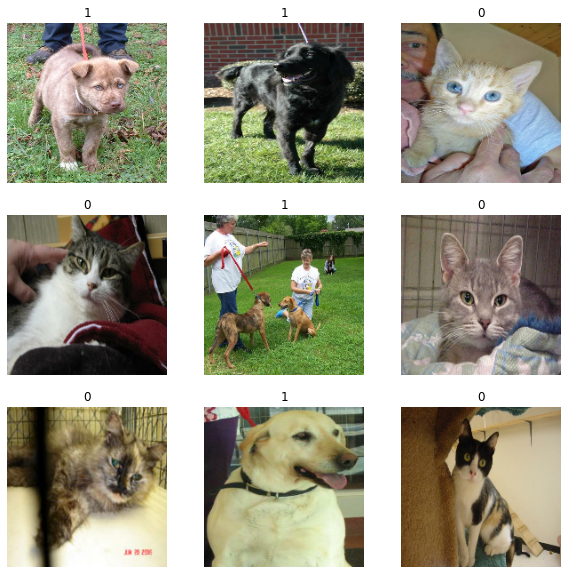

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

- When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. 


- This helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

- Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


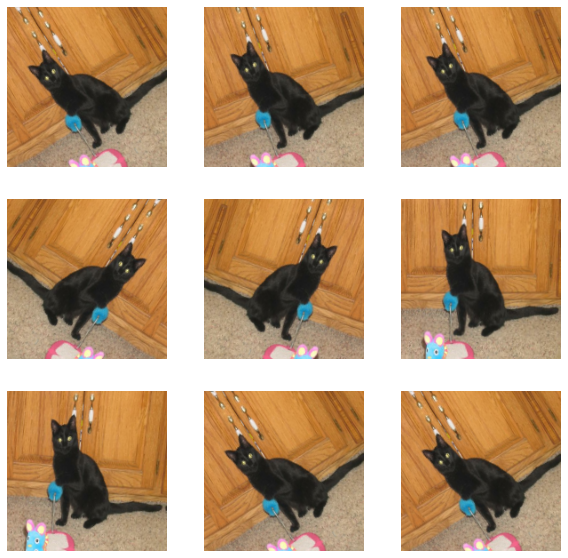

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data

- Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. 


- However, their RGB channel values are in the `[0, 255]` range. 


- This is not ideal for a neural network; in general you should seek to make your input values small. 


- Here, we will standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of our model.


## Two options to preprocess the data


There are two ways you could be using the `data_augmentation` preprocessor:


**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

- With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

- Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

- If you're training on GPU, this is the better option.


**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```


- With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

- If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.


- In our case, we'll go with the first option.


## Configure the dataset for performance

- Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:

In [13]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

### Best practice advice

Convnet architecture principles (Chollet, 2021): 

- Your model should be organized into repeated blocks of layers, usually made of 
  - multiple convolution layers (usually [Conv2d](https://keras.io/api/layers/convolution_layers/convolution2d/)) and a 
  - max pooling layer (usually [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/)).


- The number of filters in your layers should increase (usually we double it) as the size of the spatial feature maps decreases.

- Deep and narrow is better than broad and shallow.

- Introducing residual connections around blocks of layers helps you train deeper networks.

- It can be beneficial to introduce batch [normalization layers](https://keras.io/api/layers/normalization_layers/batch_normalization/) after your convolution layers.

- It can be beneficial to replace Conv2D layers with [SeparableConv2D](https://keras.io/api/layers/convolution_layers/separable_convolution2d/) layers, which are more parameter-efficient.

### Model

- Next, we'll build a small version of the [Xception network](https://arxiv.org/abs/1610.02357). 

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
 
- first layer in our model is a regular Conv2D layer. We’ll start using [SeparableConv2D](https://keras.io/api/layers/convolution_layers/separable_convolution2d/) afterwards 

- Since the assumption that underlies separable convolution, “feature channels are largely independent,” does not hold for RGB images! Red, green, and blue color channels are actually highly correlated in natural images.

- We apply a series of convolutional blocks with increasing feature depth (using a foor loop)

- We use [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) -which is similar to flatten the layer- right before the classification outout layer

- We include a `Dropout` layer before the final classification layer.

In [ ]:
def make_model(input_shape, num_classes):
 
    inputs = keras.Input(shape=input_shape)
  
    # Image augmentation block
    x = data_augmentation(inputs)

    # Image rescaling
    x = layers.Rescaling(1.0 / 255)(x)

    # Entry block
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    
    # Series of convolutional blocks with SeparableConv2D

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

             
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=2)

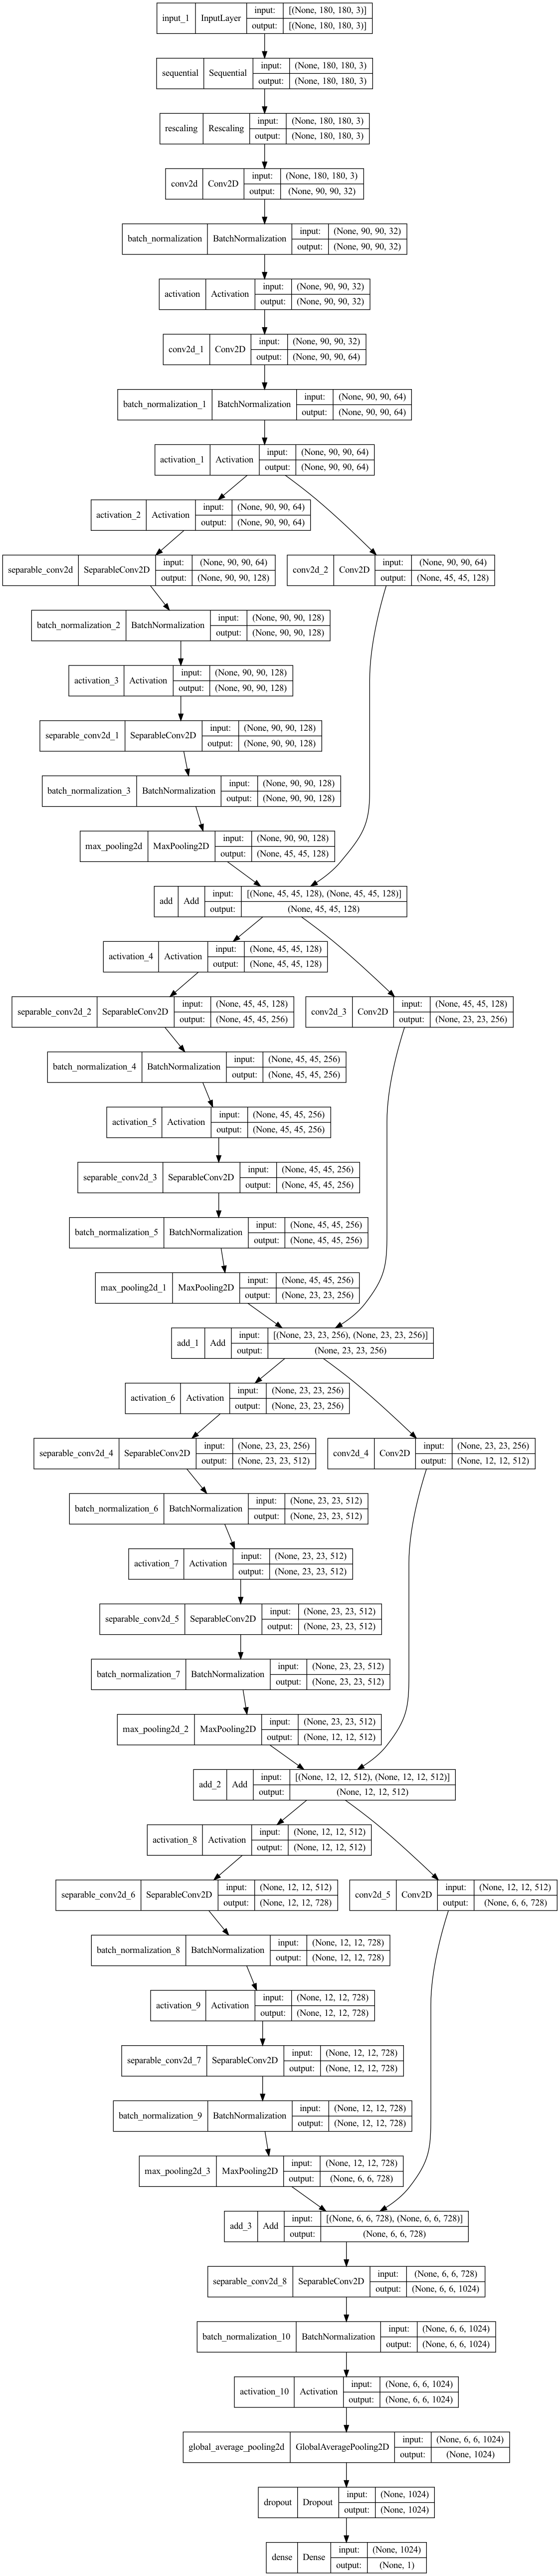

In [14]:
keras.utils.plot_model(model, show_shapes=True)

- We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

## Train the model


In [16]:
epochs = 2 # we only use 2 epochs - you should go with 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/2


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 8:30 - loss: 0.6602 - accuracy: 0.6307

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 7:34 - loss: 0.6528 - accuracy: 0.6353

402/586 [===================>..........] - ETA: 5:19 - loss: 0.6357 - accuracy: 0.6521

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 5:04 - loss: 0.6341 - accuracy: 0.6531

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 4:43 - loss: 0.6311 - accuracy: 0.6545

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 4:31 - loss: 0.6286 - accuracy: 0.6563

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.6801

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


586/586 [==============================] - 1073s 2s/step - loss: 0.6013 - accuracy: 0.6801 - val_loss: 0.6951 - val_accuracy: 0.6371
Epoch 2/2


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/586 [==============>...............] - ETA: 8:31 - loss: 0.4708 - accuracy: 0.7811

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/586 [===============>..............] - ETA: 7:37 - loss: 0.4665 - accuracy: 0.7817

402/586 [===================>..........] - ETA: 5:22 - loss: 0.4626 - accuracy: 0.7848

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


411/586 [====================>.........] - ETA: 5:06 - loss: 0.4628 - accuracy: 0.7845

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


423/586 [====================>.........] - ETA: 4:45 - loss: 0.4601 - accuracy: 0.7863

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


430/586 [=====================>........] - ETA: 4:33 - loss: 0.4588 - accuracy: 0.7873

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.7942

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 1090s 2s/step - loss: 0.4448 - accuracy: 0.7942 - val_loss: 0.3790 - val_accuracy: 0.8321


- We get to ~83% validation accuracy after training for just 2 epochs on the full dataset.


- After 50 epochs, it should be around 96%


## Run inference on new data

- Note that data augmentation and dropout are inactive at inference time.

In [17]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

img_array = keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [18]:
predictions = model.predict(img_array)

score = predictions[0]

print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 91.48 percent cat and 8.52 percent dog.
